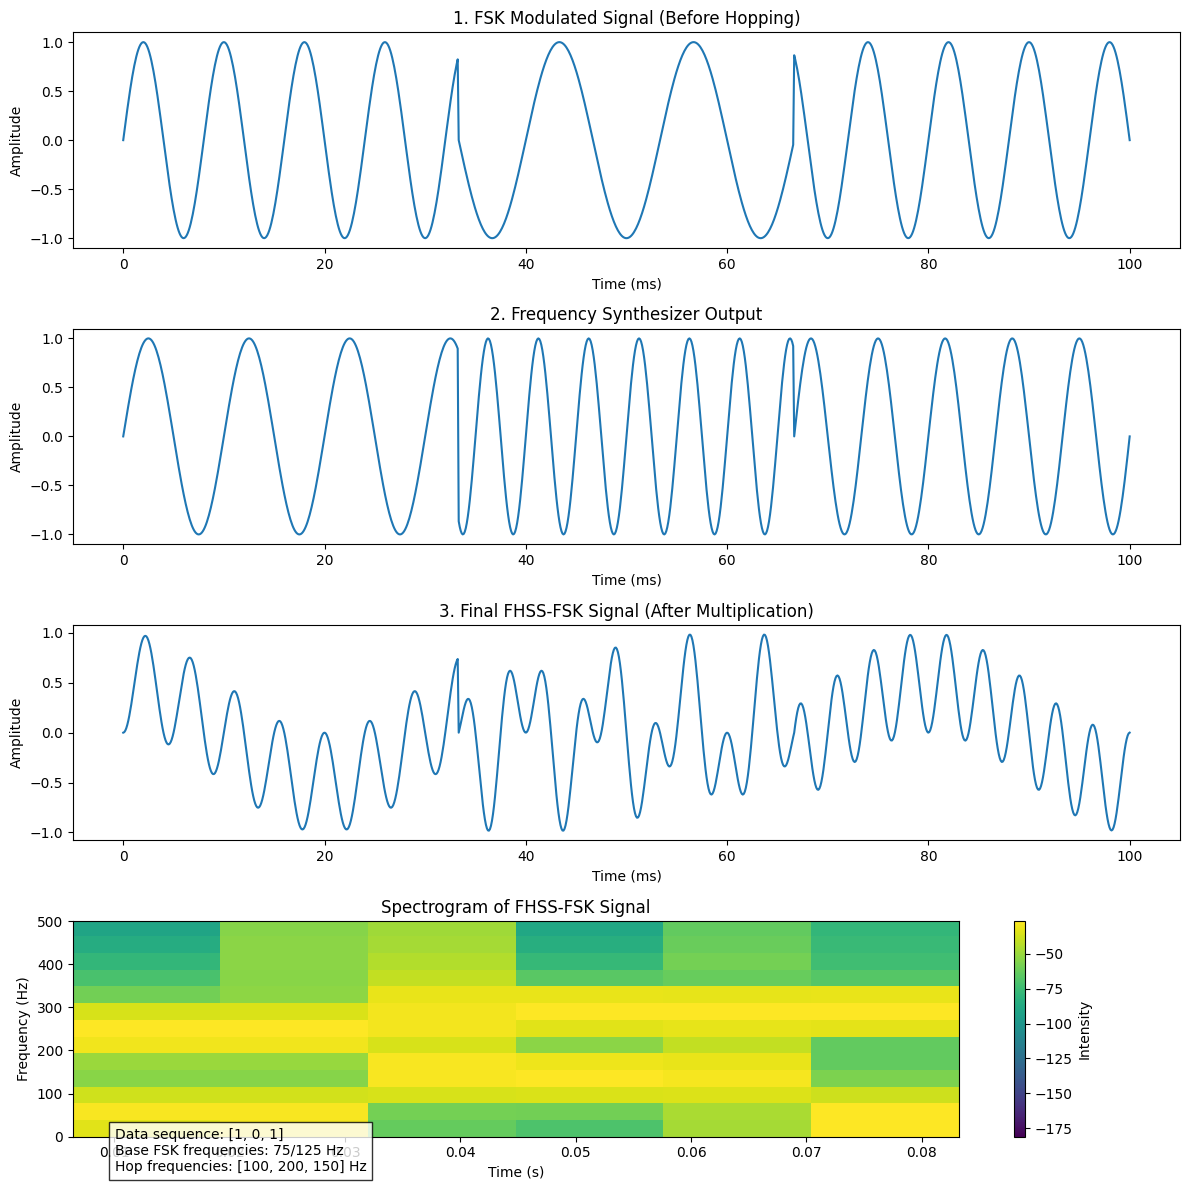

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_fhss_components(duration=0.1, sample_rate=10000):
    t = np.linspace(0, duration, int(duration * sample_rate))

    base_freq = 100
    freq_dev = 25
    hop_freqs = [100, 200, 150]
    hop_duration = duration/3
    samples_per_hop = int(hop_duration * sample_rate)
    data = [1, 0, 1]

    fsk_signal = np.zeros_like(t)
    synth_signal = np.zeros_like(t)
    fhss_signal = np.zeros_like(t)

    for i in range(3):
        start_idx = i * samples_per_hop
        end_idx = (i + 1) * samples_per_hop

        fsk_freq = base_freq + (2*data[i] - 1)*freq_dev
        fsk_signal[start_idx:end_idx] = np.sin(2*np.pi*fsk_freq*t[start_idx:end_idx])
        synth_signal[start_idx:end_idx] = np.sin(2*np.pi*hop_freqs[i]*t[start_idx:end_idx])
        fhss_signal[start_idx:end_idx] = fsk_signal[start_idx:end_idx] * synth_signal[start_idx:end_idx]

    plt.figure(figsize=(12, 12))

    plt.subplot(411)
    plt.plot(t*1000, fsk_signal)
    plt.title('1. FSK Modulated Signal (Before Hopping)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')

    plt.subplot(412)
    plt.plot(t*1000, synth_signal)
    plt.title('2. Frequency Synthesizer Output')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')

    plt.subplot(413)
    plt.plot(t*1000, fhss_signal)
    plt.title('3. Final FHSS-FSK Signal (After Multiplication)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')

    plt.subplot(414)
    plt.specgram(fhss_signal, Fs=sample_rate, NFFT=256)
    plt.title('Spectrogram of FHSS-FSK Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)  # Limit frequency axis to 500 Hz
    plt.colorbar(label='Intensity')

    plt.figtext(0.1, 0.02,
                f'Data sequence: {data}\n'
                f'Base FSK frequencies: {base_freq-freq_dev}/{base_freq+freq_dev} Hz\n'
                f'Hop frequencies: {hop_freqs} Hz',
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

visualize_fhss_components()

## Jamming in FHSS

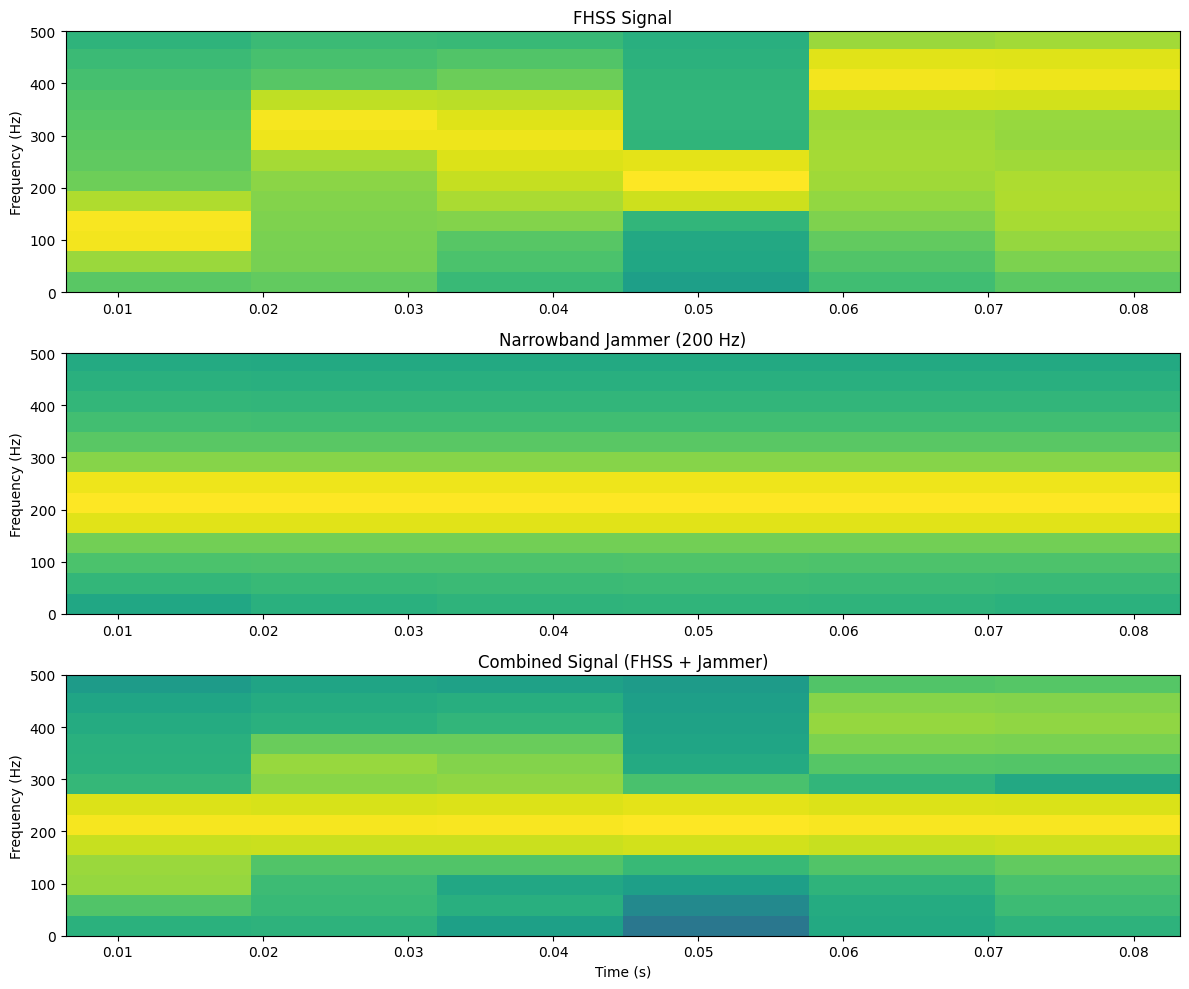

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_jamming():
    # Parameters
    duration = 0.1
    sample_rate = 10000
    t = np.linspace(0, duration, int(duration * sample_rate))
    hop_freqs = [100, 300, 200, 400, 150]  # Hz
    hop_duration = duration/5
    samples_per_hop = int(hop_duration * sample_rate)

    # Generate FHSS signal
    signal = np.zeros_like(t)
    for i, freq in enumerate(hop_freqs):
        start_idx = i * samples_per_hop
        end_idx = (i + 1) * samples_per_hop
        signal[start_idx:end_idx] = np.sin(2*np.pi*freq*t[start_idx:end_idx])

    # Generate narrowband jamming at 200Hz
    jammer = 5 * np.sin(2*np.pi*200*t)  # Stronger amplitude

    # Combined signal
    combined = signal + jammer

    # Plot
    plt.figure(figsize=(12, 10))

    # Original Signal
    plt.subplot(311)
    plt.specgram(signal, Fs=sample_rate, NFFT=256)
    plt.title('FHSS Signal')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)

    # Jammer
    plt.subplot(312)
    plt.specgram(jammer, Fs=sample_rate, NFFT=256)
    plt.title('Narrowband Jammer (200 Hz)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)

    # Combined
    plt.subplot(313)
    plt.specgram(combined, Fs=sample_rate, NFFT=256)
    plt.title('Combined Signal (FHSS + Jammer)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)

    plt.tight_layout()
    plt.show()

simulate_jamming()

## BER in FHSS

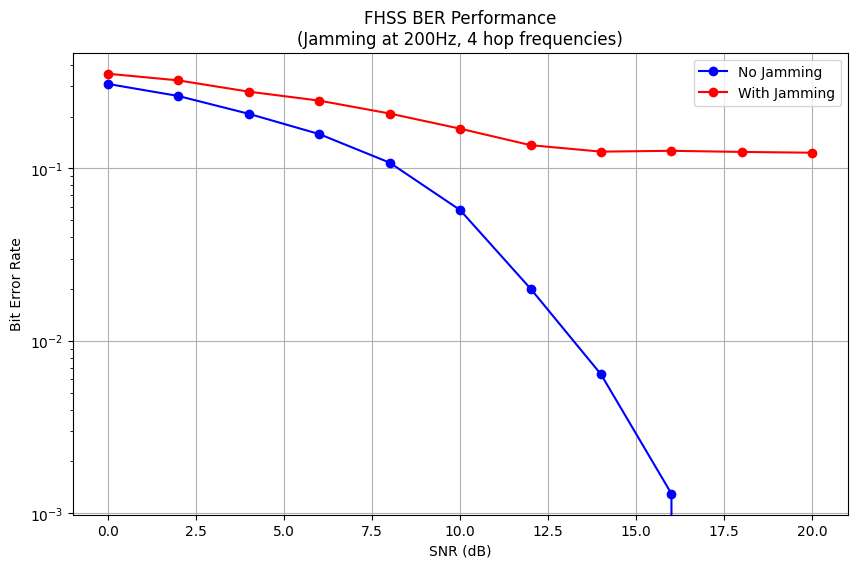

At SNR=10dB:
BER without jamming: 5.74e-02
BER with jamming: 1.70e-01

Jamming degradation factor: 3.0x


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_ber_fhss():
    # Parameters
    n_bits = 10000
    hop_freqs = [100, 200, 300, 400]
    SNR_dB = np.arange(0, 21, 2)

    # BER for different scenarios
    ber_no_jamming = []
    ber_with_jamming = []
    jammed_freq = 200  # Jamming at one hop frequency

    for snr_db in SNR_dB:
        # Convert SNR from dB
        snr = 10**(snr_db/10)
        noise_power = 1/snr

        # No jamming scenario
        errors_no_jam = 0
        # With jamming scenario
        errors_with_jam = 0

        # Transmit bits
        transmitted_bits = np.random.randint(0, 2, n_bits)

        for i in range(n_bits):
            # Select random hop frequency
            hop_freq = np.random.choice(hop_freqs)

            # Add Gaussian noise
            noise = np.random.normal(0, np.sqrt(noise_power))

            # No jamming
            received_no_jam = transmitted_bits[i] + noise
            detected_no_jam = 1 if received_no_jam > 0.5 else 0
            if detected_no_jam != transmitted_bits[i]:
                errors_no_jam += 1

            # With jamming
            jamming = 5.0 if hop_freq == jammed_freq else 0  # Strong jamming at jammed_freq
            received_with_jam = transmitted_bits[i] + noise + jamming
            detected_with_jam = 1 if received_with_jam > 0.5 else 0
            if detected_with_jam != transmitted_bits[i]:
                errors_with_jam += 1

        ber_no_jamming.append(errors_no_jam/n_bits)
        ber_with_jamming.append(errors_with_jam/n_bits)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.semilogy(SNR_dB, ber_no_jamming, 'b-o', label='No Jamming')
    plt.semilogy(SNR_dB, ber_with_jamming, 'r-o', label='With Jamming')
    plt.grid(True)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate')
    plt.title(f'FHSS BER Performance\n(Jamming at {jammed_freq}Hz, {len(hop_freqs)} hop frequencies)')
    plt.legend()
    plt.show()

    print(f"At SNR=10dB:")
    print(f"BER without jamming: {ber_no_jamming[5]:.2e}")
    print(f"BER with jamming: {ber_with_jamming[5]:.2e}")
    print(f"\nJamming degradation factor: {ber_with_jamming[5]/ber_no_jamming[5]:.1f}x")

simulate_ber_fhss()

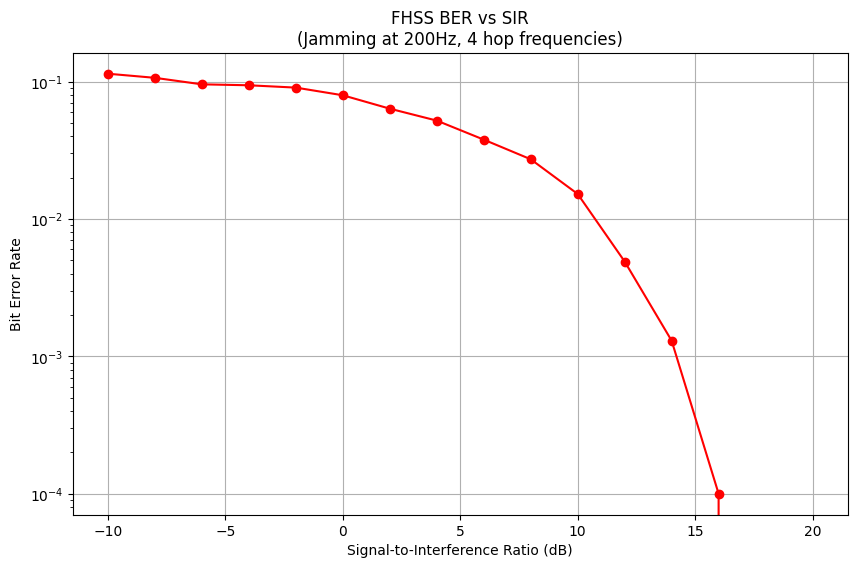

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_ber_fhss_sir():
    n_bits = 10000
    hop_freqs = [100, 200, 300, 400]
    SIR_dB = np.arange(-10, 21, 2)  # Including negative SIR

    ber_with_jamming = []
    jammed_freq = 200

    for sir_db in SIR_dB:
        # Convert SIR from dB
        sir = 10**(sir_db/10)
        interference_power = 1/sir

        errors = 0
        transmitted_bits = np.random.randint(0, 2, n_bits)

        for i in range(n_bits):
            hop_freq = np.random.choice(hop_freqs)

            # Interference power increases when frequency is jammed
            interference = np.random.normal(0, np.sqrt(interference_power)) if hop_freq == jammed_freq else 0

            received = transmitted_bits[i] + interference
            detected = 1 if received > 0.5 else 0
            if detected != transmitted_bits[i]:
                errors += 1

        ber_with_jamming.append(errors/n_bits)

    plt.figure(figsize=(10, 6))
    plt.semilogy(SIR_dB, ber_with_jamming, 'r-o')
    plt.grid(True)
    plt.xlabel('Signal-to-Interference Ratio (dB)')
    plt.ylabel('Bit Error Rate')
    plt.title(f'FHSS BER vs SIR\n(Jamming at {jammed_freq}Hz, {len(hop_freqs)} hop frequencies)')
    plt.show()

simulate_ber_fhss_sir()